Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
from scipy.stats import chi2_contingency, chi2 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Считываем и изучаем данные

In [3]:
df = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/my_lessons/Проект_1_Задание_2.csv', sep=';')

In [4]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [5]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [8]:
# a - контрольная группа
# b - тестовая

In [9]:
df['testgroup'].value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

In [10]:
df_control = df.query("testgroup == 'a'")
df_test = df.query("testgroup == 'b'")

In [11]:
#Смотрим на описательные статистики

pd.concat([df_control['revenue'].describe(), df_test['revenue'].describe()], axis=1)

,revenue,revenue
count,202103.000000,202667.000000
mean,25.413720,26.751287
std,920.768137,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,37433.000000,4000.000000


<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

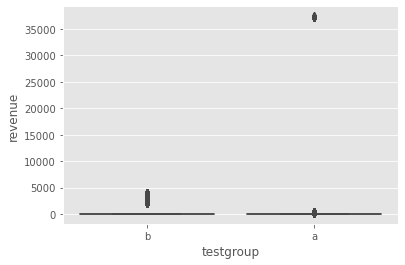

In [12]:
# Смотрит распределение revenue. Пока не очень понятно, много оттягивают на себя нулевые значения

sns.boxplot(x='testgroup', y='revenue', data=df)

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

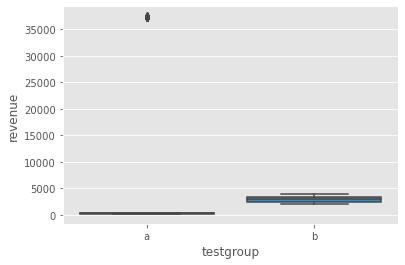

In [13]:
# То же самое, только по платящим пользователям. Видно, что в контрольной группе есть выбросы,
# основные значения зажаты в некоем диапазоне.

sns.boxplot(x='testgroup', y='revenue', data=df[df['revenue']>0])

In [14]:
# Путем нехитрых манипуляций, понимаем, что значения котрольной группы распределены след.образом

df_control.revenue.value_counts(bins=[0, 1, 199, 401, 30000, 40000])

(-0.001, 1.0]         200175
(199.0, 401.0]          1805
(30000.0, 40000.0]       123
(1.0, 199.0]               0
(401.0, 30000.0]           0
Name: revenue, dtype: int64

<AxesSubplot:>

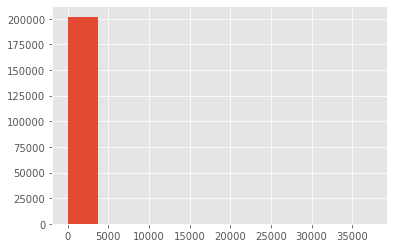

In [15]:
# Визуализируем

df_control.revenue.hist()

In [16]:
# Проделываем то же самое с тестовой группой

df_test.revenue.value_counts(bins=[0, 1, 1999, 40000])

(-0.001, 1.0]        200862
(1999.0, 40000.0]      1805
(1.0, 1999.0]             0
Name: revenue, dtype: int64

<AxesSubplot:>

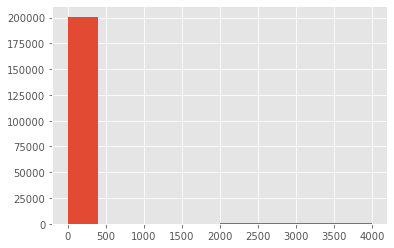

In [17]:
df_test.revenue.hist()

In [18]:
# Очевидно, что распределения revenue в группах далеки от нормального...
# Логарифмирование не поможет, избавляться от выбросов в контрольной группе тоже нельзя

ARPU - средний доход на пользователя

ARPPU - средний доход на платящего пользователя

In [19]:
# В нашем случае ARPU будет совпадать со средним в группе. Выведем его еще раз

In [20]:
print(f"ARPU тестовой группы {round(df_test['revenue'].mean(), 1)}", \
      f"ARPU котрольной группы {round(df_control['revenue'].mean(), 1)}", \
      sep="\n")

ARPU тестовой группы 26.8
ARPU котрольной группы 25.4


In [21]:
# При этом важно отметить, что процент платящих пользователей составляет менее 1% 

display(df_control[df_control['revenue']>0].shape[0] / df_control.shape[0]  * 100)
display(df_test[df_test['revenue']>0].shape[0] / df_test.shape[0]  * 100)

0.9539690157988748

0.8906235351586593

In [22]:
# Тест Левена на гомогенность дисперсий показывает, что они более менее одинаковы...
# Учитывая характер распределения, полагаю, что сильно влияет большое количество нулевых значений

ss.levene(df_control['revenue'], df_test['revenue'])

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Итак, можем констатировать увеличение ARPU на 5%. Является ли это статистически значимым?
Для проверки нужно подобрать подходящий стат.тест.

В теории тест Стьюдента (t-тест) можно использовать при выполнении условий 1)нормальности распределения и 2)гомогенности дисперсий. При этом если количество наблюдений достаточно большое допустимо отклониться от требования нормальности распределения.

Возможно, t-тест здесь и сработает, т.к. согласно ЦПТ выборочные средние имеют нормальное распределение, если количество наблюдений достаточно большое (у нас почти 2 тыс.), даже при не нормальности распределения ГС. 

Стоит отметить, что характер распределения и описательные статистики свидетельствуют о том, что среднее не лучшая мера центральной тенденции в имеющихся данных. Но, во-первых, мы проверяем изменился ли ARPU (а это среднее), во-вторых, проверять медиану бутстрэпом не имеет смылса, т.к. она в обеих группах == 0.

Непараметрический тест Манна-Уитни тоже не совсем подходит, т.к. сравнивает не метрику, а среднее рангов.

Тем не менее, посмотрим на результаты T-testа, U-testа и бутстрэпа по среднему.

In [23]:
control_all_users = df_control['revenue']
test_all_users = df_test['revenue']

In [24]:
# T-test ARPU

ss.ttest_ind(control_all_users, test_all_users)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [25]:
# U-test ARPU

ss.mannwhitneyu(control_all_users, test_all_users)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

In [26]:
# Используем заготовленную функцию бутстрэп

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    

    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

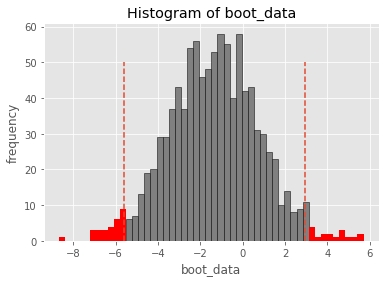

0.5236470791482337

In [27]:
# bootstrap по среднему ARPU

booted_data = get_bootstrap(control_all_users, test_all_users, statistic = np.mean) 
booted_data['p_value']

Результаты трех тестов не позволяют отклонить нулевую гипотезу о равентстве средних. Считаю возможным по совокупности результатов тестов сделать вывод об отстуствии статистически значимых различий ARPU в группах.

Теперь посмотрим на ARPPU (среднее revenue по платящим юзерам)


In [28]:
print(f"ARPPU тестовой группы {round(df_test[df_test['revenue']>0].revenue.mean(), 1)}", \
    f"ARPPU котрольной группы {round(df_control[df_control['revenue']>0].revenue.mean(), 1)}", \
     sep='\n')

ARPPU тестовой группы 3003.7
ARPPU котрольной группы 2664.0


In [29]:
m = round((df_test[df_test['revenue']>0].revenue.mean() - df_control[df_control['revenue']>0].revenue.mean())\
    / df_test[df_test['revenue']>0].revenue.mean() *100, 1)
    
print(f'ARPPU тестовой группы увеличился на {m} %')

ARPPU тестовой группы увеличился на 11.3 %


In [30]:
control_pay_users = df_control[df_control['revenue'] > 0]['revenue']
test_pay_users = df_test[df_test['revenue'] > 0]['revenue']

In [31]:
# Посмотрим на статистики платящих пользователей

pd.concat([control_pay_users.describe(), test_pay_users.describe()], axis=1)

,revenue,revenue
count,1928.000000,1805.000000
mean,2663.998444,3003.658172
std,9049.039763,572.619709
min,200.000000,2000.000000
25%,257.000000,2513.000000
50%,311.000000,3022.000000
75%,361.000000,3478.000000
max,37433.000000,4000.000000


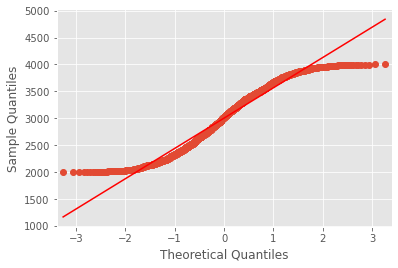

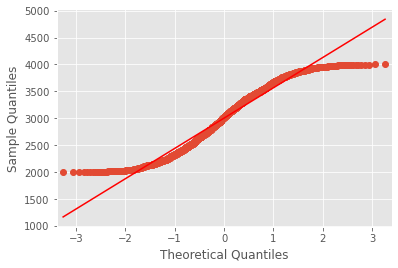

In [32]:
# Визуализируем проверку на нормальность распределения

sm.qqplot(test_pay_users, line='r')

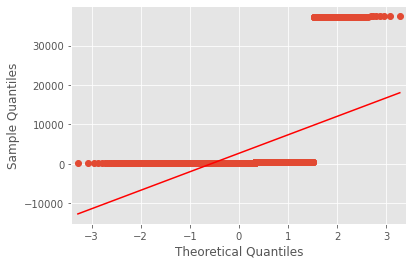

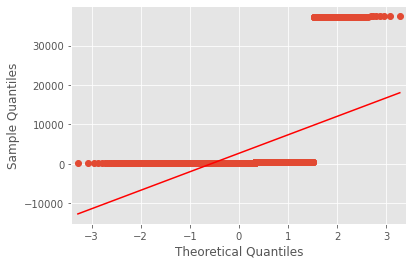

In [33]:
sm.qqplot(control_pay_users, line='r')

In [34]:
# Тест Шапиро подтверждает вывод о ненормальности распределения

ss.shapiro(test_pay_users.sample(1000, random_state=17))

ShapiroResult(statistic=0.9613319039344788, pvalue=1.2883664412895895e-15)

In [35]:
# Тест Левена на гомогенность дисперсий показывает, что условие гомогенности НЕ выполняется

ss.levene(control_pay_users, test_pay_users)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Распределения в группах по-прежнему не являются нормальными, а дисперсии стали неоднородными, 
что не позволяет применить t-тест.

Посмотрим, что нам дадут критерий Манна-Уитни, бутстрэп по среднему.

In [36]:
# U-test ARPPU

ss.mannwhitneyu(control_pay_users, test_pay_users)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

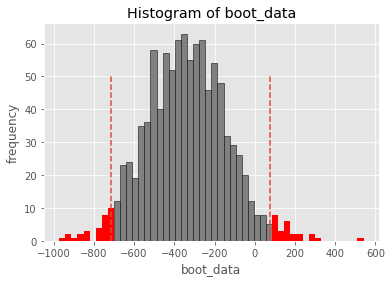

0.09049702662062578

In [37]:
# bootstrap по среднему ARPPU

booted_data = get_bootstrap(control_pay_users, test_pay_users, statistic = np.mean) 
booted_data['p_value']

В данном случае получили противоречивые результаты: Манна-Уитни позволяет отклонить нулевую гипотезу о равенстве средних, а бутстрап не позволяет. Но, как уже было отмечено, Манна-Уитни как непараметрический аналог t-теста оценивает среднее рангов (ближе к медиане), а бутстрэп среднее распределения, т.е. нужный нам ARPPU. Поэтому общий вывод: недостаточно оснавний для отклонения нулевой гипотезы о равенстве средних.

Кроме того, рост ARPPU далеко не всегда явлется благом для продукта. В нашем случае точно не благо, т.к. paying share (доля платящих пользователей уменьшилась) на 6,6%*

In [38]:
#*
(control_pay_users.shape[0] / df_control.shape[0] *100\
- test_pay_users.shape[0] / df_test.shape[0] *100)\
/(control_pay_users.shape[0] / df_control.shape[0] *100) *100

6.6402031503264904

In [39]:
# Проверим стат.значимость изменения paying share методом хи-квадрат, 
# т.к. будем оперировать номинативными переменными

In [40]:
df['is_pay'] = df['revenue'].apply(lambda x: 'pay' if x > 0 else 'notpay')
pd.crosstab(df.is_pay, df.testgroup)

testgroup,a,b
is_pay,,
notpay,200175,200862
pay,1928,1805


In [41]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.is_pay, df.testgroup))

In [42]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')


Отклоняем H0


In [43]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Результат теста показал, что статистически значимо уменьшился paying share, что для продукта не есть хорошо. Вкупе с тем, что мы не смогли в результате тестов доказать стат.значимость роста ни ARPU, ни ARPPU, тестовый набор акционных предложений нельзя признать более успешным.

Но не все так однозначно)

В тестовой группе в 10 раз выросла медиана и др.квартили. В целом распределение revenue в тестовой группе более равномерное, без выбросов. Предположу, такое распределение предпочтительней для денежных метрик продукта, т.к. более устойчиво и предсказуемо будет вести себя тот же ARPU.

Проверим гипотезу: в тестовой группе при отвале рандомных 5% платящих пользователей ARPU 
будет более стабилен нежели в контрольной группе (диапазон изменений ARPU в тесте меньше, чем в контроле)

In [44]:
ARPU_control_mean = df_control['revenue'].mean()
ARPU_test_mean = df_test['revenue'].mean()

l = []
m = []

for i in tqdm(range(500)):
    # получаем рэндом сэмпл 5% платящих пользователей 
    users_c = df_control.query("revenue > 0")['user_id'].sample(frac=0.05, replace=True)
    users_t = df_test.query("revenue > 0")['user_id'].sample(frac=0.05, replace=True)
        
    # получаем серию revenue по группам исключая рэндом сэмпл 5%
    control_all_sample = df_control.query("user_id not in @users_c")['revenue']
    test_all_sample = df_test.query("user_id not in @users_t")['revenue']
    
    # считаем % отклонения ARPU сэмпла от ARPU в группе и записываем сперва в список, потом в серию
    l.append((ARPU_control_mean - control_all_sample.mean()) / ARPU_control_mean * 100)
    m.append((ARPU_test_mean - test_all_sample.mean()) / ARPU_test_mean * 100)
        
control_mean_diff = pd.Series(l)
test_mean_diff = pd.Series(m)


  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
pd.concat([control_mean_diff.describe(), test_mean_diff.describe()], axis=1)

,0,1
count,500.000000,500.000000
mean,4.884827,4.824188
std,1.636528,0.124882
min,0.510702,4.415312
25%,3.411685,4.735181
50%,4.828536,4.818792
75%,5.573490,4.916203
max,9.168238,5.207422


  0%|          | 0/1000 [00:00<?, ?it/s]

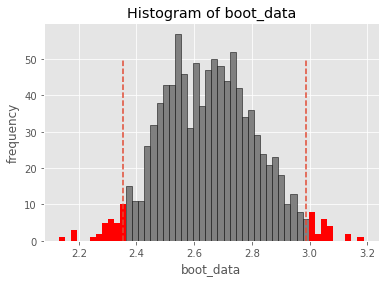

4.770160621223616e-58

In [46]:
# Поскольку проверяем диапазон изменчивости для оценки нам нужна дисперисия и бутстрэп

booted_data = get_bootstrap(control_mean_diff, test_mean_diff, statistic = np.var) 
booted_data['p_value']

p-value < 0,05 - Тестом подтверждена гипотеза о меньшей изменчивости ARPU в тестовой группе при УМЕНЬШЕНИИ количества платящих пользователей. Проверим аналогичную гипотезу для случая УВЕЛИЧЕНИЯ рандомных платящих пользователей на те же 5%.

In [47]:
ARPU_control_mean = df_control['revenue'].mean()
ARPU_test_mean = df_test['revenue'].mean()

l = []
m = []

for i in tqdm(range(500)):
    # получаем рэндом сэмпл 5% платящих пользователей 
    users_c = df_control.query("revenue > 0")['revenue'].sample(frac=0.05, replace=True)
    users_t = df_test.query("revenue > 0")['revenue'].sample(frac=0.05, replace=True)
        
    # получаем серию revenue по группам ВКЛЮЧАЯ рэндом сэмпл 5%
    control_add_sample = pd.concat([control_all_users, users_c])
    test_ad_sample = pd.concat([test_all_users, users_t])
    
    # считаем % отклонения ARPU сэмпла от ARPU в группе и записываем сперва в список, потом в серию
    l.append((ARPU_control_mean - control_add_sample.mean()) / ARPU_control_mean * 100)
    m.append((ARPU_test_mean - test_ad_sample.mean()) / ARPU_test_mean * 100)
        
control_mean_diff = pd.Series(l)
test_mean_diff = pd.Series(m)

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
pd.concat([control_mean_diff.describe(), test_mean_diff.describe()], axis=1)

,0,1
count,500.000000,500.000000
mean,-4.824149,-4.938045
std,1.799188,0.096784
min,-11.338225,-5.221420
25%,-6.271839,-5.000209
50%,-4.835712,-4.936419
75%,-3.402737,-4.866844
max,-0.505763,-4.691462


  0%|          | 0/1000 [00:00<?, ?it/s]

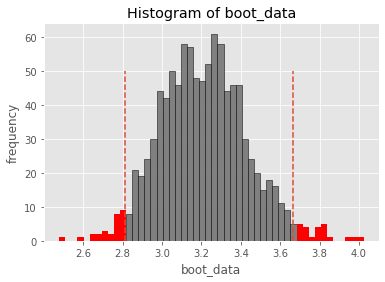

2.248162647373573e-48

In [49]:
# Поскольку проверяем диапазон изменчивости для оценки нам нужна дисперисия и бутстрэп

booted_data = get_bootstrap(control_mean_diff, test_mean_diff, statistic = np.var) 
booted_data['p_value']

Вариативность отклонения ARPU в контрольной группе при изменении количества платящих пользователей стат. значимо больше чем в тестовой, что подтверждает гипотезу о более "стабильном" распределении revenue в тесте. Для бизнеса это может быть полезным, например, при планировании различных денежных метрик, т.к. эти метрики будут менее чувствительны к неизбежным колебаниям количества платящих пользователей.

В целом можно сделать следующий вывод:

В результате проведенного А/В теста мы не можем с опорой на статистику утверждать, что тестовый акционный набор позволит нам зарабатывать больше. Напротив, такая важная метрика как доля платящих пользователей стат.значимо ухудшилась. В то же время в результате А/В теста наблюдаем полезный эффект в виде более равномерного распределения revenue и 10-ти кратного увеличения медианы. Изменение распределения как в тестовой группе может принести бизнесу пользу. Поэтому есть основания обратить внимание продакта на этот эффект и обсудить с ним, что более важно для развития продукта.